In [1]:
"""
    Author : Teaching Assistants of LELEC210X - UCLouvain
    Date : 21/11/2023

    Code description :
    __________________
    Check consistency between mel vector on Python and on C.

"""
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
import sounddevice as sd
from scipy.signal import kaiserord, lfilter, firwin
import librosa # For audio signal computations as MFCC

from classification.datasets import Dataset

## 2) Real audio signal test

In [2]:
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


### Low-Pass Filter (LPF) with $f_c = 5kHz$ then downsample the signal to $f_{s2} = \frac{f_s}{4} = 11025 Hz $ 

Playing and showing data for :  C:\Users\leblanco.OASIS\Documents\IngeCivilPHD\teaching\LELEC2103\LELEC210X-private\classification\src\classification\datasets\soundfiles\helicopter_21.wav
Maximal value: 0.5001303440264947


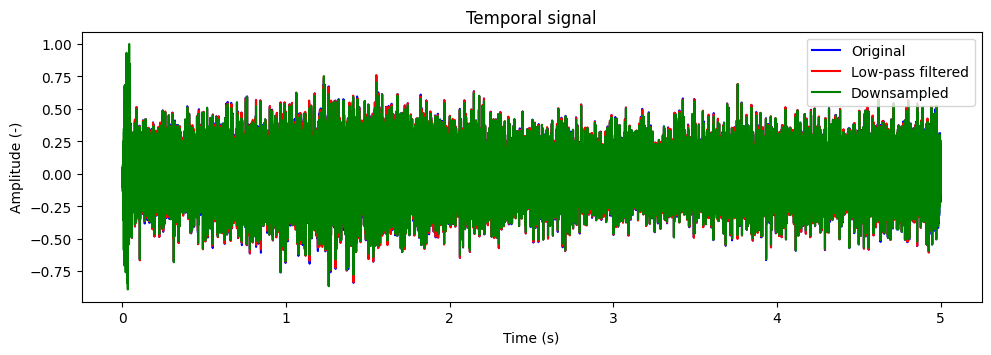

In [3]:
audiotype = 'real' # else sine example

if (audiotype == 'real'):
    "Size of "
    Nft=512
    "Target sampling frequency"
    fs2 = 11025

    sound = dataset["helicopter", 14]
    print('Playing and showing data for : ', sound)
    audio, fs = sf.read(sound)

    " LPF "
    # The Nyquist rate of the signal.
    nyq_rate = fs / 2.0
    # The desired width of the transition from pass to stop,
    # relative to the Nyquist rate.  We'll design the filter
    # with a 5 Hz transition width.
    width = 50.0/nyq_rate
    # The desired attenuation in the stop band, in dB.
    ripple_db = 60.0
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
    cutoff_hz = 5000.0
    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    filtered_x = lfilter(taps, 1.0, audio)
    filtered_x = filtered_x[(N-1)//2:]

    audio2 = signal.resample(audio, len(audio)*fs2//fs)
    L = len(audio)
    L2 = len(audio2)

else:
    fsinus = 250 # frequency of the sinusoid
    t = np.arange(11025*5)/11025 # time instants
    audio2 = np.sin(2*np.pi*fsinus*t)
    L2 = len(audio2)
    # audiocut = np.cos(2*np.pi*2*np.arange(L2)/L2) + np.cos(2*np.pi*5*np.arange(L2)/L2)

"/!\/!\ Cut signal"
# audiocut = np.copy(audio2[:L2-L2%Nft]) # Doesn't cut in this case
audiocut = audio2[:512*1]
Lcut = len(audiocut)

maxval = np.max(np.abs(audiocut))
print('Maximal value: {}'.format(maxval) )
audiocut/=maxval

"Play audio"
sd.play(audio2, fs2)

"Plots"
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.0, 0.0, 0.9, 0.9])
ax1.plot(np.arange(L)/fs, audio, 'b', label='Original')
ax1.plot(np.arange(len(filtered_x))/fs, filtered_x, 'r', label='Low-pass filtered')
ax1.plot(np.arange(L2)/fs2, audio2, 'g', label='Downsampled')

"compute stft"
audiomat = audiocut.reshape(Lcut//Nft,Nft)
audioham = np.outer(np.ones(Lcut//Nft), np.hamming(Nft))*audiomat
stft = np.fft.fft(audioham, axis=1)
stft = stft[:,:Nft//2]
# stft = librosa.stft(audiocut, n_fft=Nft, hop_length=Nft+1)


# ax1.plot(np.abs(stft[10,:]), label='Downsampled')
# # ax1.set_ylim(0,1)
ax1.legend()
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude (-)")
ax1.set_title('Temporal signal')
plt.show()

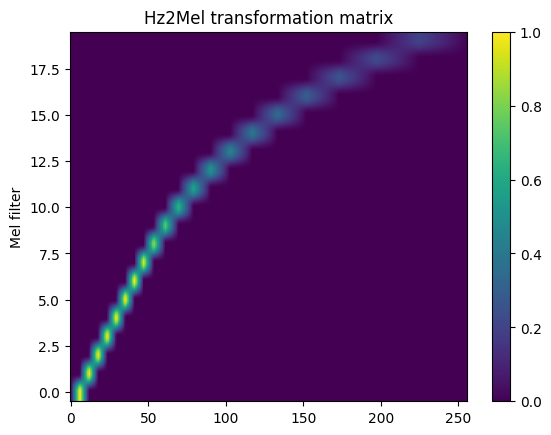

height = 20, width = 256


In [4]:
Nft=512 
fs = 11025 # Hz
n_mels = 20

"Using librosa library"
plt.figure()
mel = librosa.filters.mel(sr=fs, n_fft=Nft, n_mels=n_mels)
mel = mel[:,:-1]
mel = mel/np.max(mel)

plt.imshow(mel, aspect='auto')
plt.gca().invert_yaxis()
plt.ylabel('Mel filter')
plt.colorbar()
plt.title('Hz2Mel transformation matrix')
plt.show()

H, W = mel.shape
print('height = {}, width = {}'.format(H,W))

# Compute mel vector

In [5]:
tmp = [  0.000000, \
 0.000000, \
 0.000000, \
 0.218750, \
 20.218750, \
 155.843750, \
 145.781250, \
 37.875000, \
 11.812500, \
 10.812500, \
 17.968750, \
 16.968750, \
 9.593750, \
 43.281250, \
 43.531250, \
 15.343750, \
 7.031250, \
 8.781250, \
 5.968750, \
 1.968750]

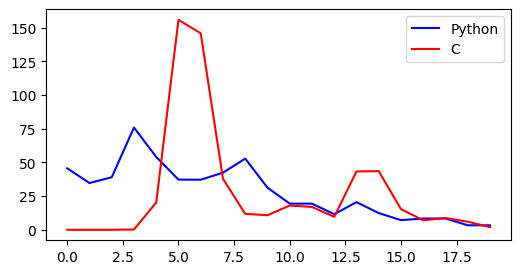

In [6]:
nmel = mel.shape[0]
mel_fb = []
first_inds = np.zeros(nmel)
Ncoeffs = np.zeros(nmel)

for line in range(nmel):
    mel_fb += [mel[line, mel[line,:]!=0],]
    nonzerocoeffs = np.where(mel[line,:]!=0)[0]
    first_inds[line] = nonzerocoeffs[0]
    Ncoeffs[line] = len(nonzerocoeffs)

first_inds = first_inds.astype(int)
Ncoeffs = Ncoeffs.astype(int)

melvec = np.zeros(nmel)
for i in np.arange(nmel):
    melvec[i] = mel_fb[i]@np.abs(stft[0])[first_inds[i]:first_inds[i]+Ncoeffs[i]]


plt.figure(figsize=(6,3))
plt.plot(melvec, 'b', label='Python')
plt.plot(tmp, 'r', label='C')
plt.legend()
plt.show()